In [ ]:
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 427 kB/s 


In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class Attention(nn.Module):              
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)           # (b, n(65), dim*3) ---> 3 * (b, n, dim)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)          # q, k, v   (b, h, n, dim_head(64))

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert  image_height % patch_height ==0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))					# nn.Parameter()定义可学习参数
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)        # b c (h p1) (w p2) -> b (h w) (p1 p2 c) -> b (h w) dim
        b, n, _ = x.shape           # b表示batchSize, n表示每个块的空间分辨率, _表示一个块内有多少个值

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)  # self.cls_token: (1, 1, dim) -> cls_tokens: (batchSize, 1, dim)  
        x = torch.cat((cls_tokens, x), dim=1)               # 将cls_token拼接到patch token中去       (b, 65, dim)
        x += self.pos_embedding[:, :(n+1)]                  # 加位置嵌入（直接加）      (b, 65, dim)
        x = self.dropout(x)

        x = self.transformer(x)                                                 # (b, 65, dim)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]                   # (b, dim)

        x = self.to_latent(x)                                                   # Identity (b, dim)
        #print(x.shape)

        return self.mlp_head(x) 

In [ ]:
"""
model_vit = ViT(
        image_size = 224,
        patch_size = 16,
        num_classes = 10,
        dim = 256,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
)

img = torch.randn(16, 3, 256, 256)

preds = model_vit(img) 
print(preds.shape)
"""


'\nmodel_vit = ViT(\n        image_size = 224,\n        patch_size = 16,\n        num_classes = 10,\n        dim = 256,\n        depth = 2,\n        heads = 4,\n        mlp_dim = 128,\n        dropout = 0.1,\n        emb_dropout = 0.1\n)\n\nimg = torch.randn(16, 3, 256, 256)\n\npreds = model_vit(img) \nprint(preds.shape)\n'

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
#from vit_pytorch import ViT, SimpleViT

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tra_acc=[]
test_acc=[]
tra_loss=[]
test_loss=[]

def main():
    # 加载和预处理数据集
    trans_train = transforms.Compose(
        [transforms.RandomResizedCrop(224),  
         # 将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为制定的大小；
         # （即先随机采集，然后对裁剪得到的图像缩放为同一大小） 默认scale=(0.08, 1.0)
         transforms.RandomHorizontalFlip(),  # 以给定的概率随机水平旋转给定的PIL的图像，默认为0.5；
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])])

    trans_valid = transforms.Compose(
        [transforms.Resize(256),  # 是按照比例把图像最小的一个边长放缩到256，另一边按照相同比例放缩。
         transforms.CenterCrop(224),  # 依据给定的size从中心裁剪
         transforms.ToTensor(),  # 将PIL Image或者 ndarray 转换为tensor，并且归一化至[0-1]
         # 归一化至[0-1]是直接除以255，若自己的ndarray数据尺度有变化，则需要自行修改。
         transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])])  # 对数据按通道进行标准化，即先减均值，再除以标准差，注意是 hwc

    trainset = torchvision.datasets.CIFAR10(root="./cifar10", train=True, download=True, transform=trans_train)
    #trainset = torchvision.datasets.LFWPeople(root="./lfw", split='train', download=True, transform=trans_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=False, transform=trans_train)
    #testset = torchvision.datasets.LFWPeople(root='./lfw', split='test', download=True, transform=trans_valid)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                             shuffle=False)

   # classes = ('plane', 'car', 'bird', 'cat',
   #            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    model = ViT(
               image_size = 224,
               patch_size = 16,
               num_classes = 10,
               dim = 256,
               depth = 12,
               heads = 3,
               mlp_dim = 128,
               dropout = 0.1,
               emb_dropout = 0.1
    )

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  # 损失函数
    # 只需要优化最后一层参数
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)  # 优化器

    # train
    train(model, trainloader, testloader, 5, optimizer, criterion)


# 计算准确率
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


# 显示图片
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 定义训练函数
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device)  # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()#测试
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device)  # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                    "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                    % (epoch, train_loss / len(train_data) ,
                       train_acc / len(train_data), valid_loss / len(valid_data),
                       valid_acc / len(valid_data)))
            tra_acc.append(train_acc / len(train_data))
            tra_loss.append(train_loss / len(train_data))
            test_acc.append(valid_acc / len(valid_data))
            test_loss.append(valid_loss / len(valid_data))

        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

"""
def get_vit_model():
    v = SimpleViT(
        image_size=224,
        patch_size=16,
        num_classes=10,
        dim=256,
        depth=2,
        heads=4,
        mlp_dim=128
    )
    return v
"""

if __name__ == '__main__':
    main()



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Epoch 0. Train Loss: 2.012061, Train Acc: 0.232031, Valid Loss: 2.171467, Valid Acc: 0.177910, Time:  00:02:19
Epoch 1. Train Loss: 1.932555, Train Acc: 0.289648, Valid Loss: 2.024487, Valid Acc: 0.235260, Time:  00:02:36
Epoch 2. Train Loss: 1.849452, Train Acc: 0.329688, Valid Loss: 1.959836, Valid Acc: 0.268917, Time:  00:02:35
Epoch 3. Train Loss: 1.759242, Train Acc: 0.365137, Valid Loss: 1.897448, Valid Acc: 0.296173, Time:  00:02:28
Epoch 4. Train Loss: 1.720370, Train Acc: 0.367676, Valid Loss: 1.853336, Valid Acc: 0.312572, Time:  00:02:28
Epoch 5. Train Loss: 1.656592, Train Acc: 0.398047, Valid Loss: 1.809178, Valid Acc: 0.333355, Time:  00:02:28
Epoch 6. Train Loss: 1.651195, Train Acc: 0.418945, Valid Loss: 1.770793, Valid Acc: 0.348721, Time:  00:02:27
Epoch 7. Train Loss: 1.580709, Train Acc: 0.413672, Valid Loss: 1.734892, Valid Acc: 0.364066, Time:  00:02:28
Epoch 8. Train Loss: 1.520357, Train Acc: 0.456055, Val

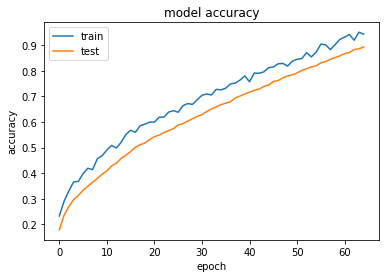

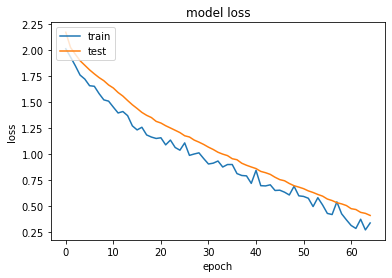

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tra_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(tra_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()